# Cvičení 06 -- CNN, Salent map

## 1. Import a nastavení zařízení

import a konfigurace GPU/CPU

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Nastavení zařízení
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Používáme zařízení: {device}")

Používáme zařízení: cuda


## 2. Definice architektury CNN

Jednoduchá CNN architektura pro MNIST (SimpleCNN)

In [10]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Konvoluční vrstva 1: 1 kanál (grayscale) -> 10 kanálů
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.pool = nn.MaxPool2d(2)
        # Konvoluční vrstva 2: 10 kanálů -> 20 kanálů
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        
        # Plně propojené vrstvy
        # Výpočet dimenze (20 * 4 * 4) po dvou MaxPoolech
        self.fc1 = nn.Linear(320, 50) 
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # Conv1 -> ReLU -> Pool
        x = self.pool(F.relu(self.conv1(x)))
        # Conv2 -> Dropout -> ReLU -> Pool
        x = self.pool(F.relu(self.conv2_drop(self.conv2(x))))
        
        # Flattening (zploštění)
        x = x.view(x.size(0), -1) 
        
        # FFNN
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = SimpleCNN().to(device) # Přesun modelu na zařízení (CPU/GPU)
print("Model SimpleCNN je definován a přesunut na zařízení.")

Model SimpleCNN je definován a přesunut na zařízení.


## 3. Načtení dat a trénink

Načtení MNIST, trénovací cyklus (3 epochy)

In [15]:
# Transformace a normalizace
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Načtení dat
train_loader = DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transform),
    batch_size=64, shuffle=True
)
test_loader = DataLoader(
    datasets.MNIST('./data', train=False, transform=transform),
    batch_size=1000, shuffle=True
)

optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.NLLLoss()

# Funkce pro testování
def test(model, device, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f'\nTest Accuracy: {accuracy:.4f}\n')
    return accuracy

# Hlavní trénovací smyčka
num_epochs = 3 
for epoch in range(1, num_epochs + 1):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch} dokončena.')

# Vyhodnocení finální přesnosti
model.eval()
test(model, device, test_loader)
print("Model je natrénován a připraven k vizualizaci.")

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:01<00:00, 7170910.22it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 250392.10it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 2106036.59it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 2235715.15it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Epoch 1 dokončena.
Epoch 2 dokončena.
Epoch 3 dokončena.

Test Accuracy: 0.9582

Model je natrénován a připraven k vizualizaci.


## 4. Vizualizace aktivací feature maps

Zobrazení, co se naučila první konvoluční vrstva.

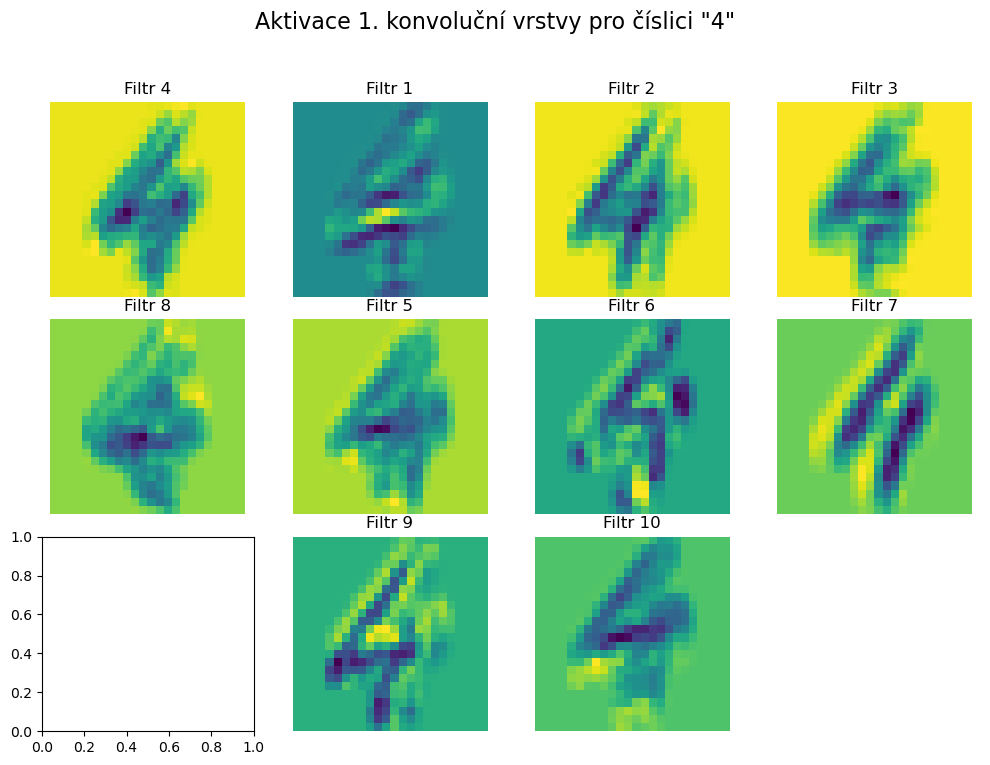

In [31]:
# 1. Získání jednoho testovacího vzorku
data_iter = iter(test_loader)
test_image_batch, test_label_batch = next(data_iter)
sample_image = test_image_batch[0].unsqueeze(0).to(device)
sample_label = test_label_batch[0].item()

# Nastavíme requires_grad_(True) pro Saliency Map v dalším kroku
sample_image.requires_grad_(True) 

# 2. Získání výstupu (aktivace) z vrstvy 'conv1'
activation = {}
def get_activation(name):
    """Pomocná funkce pro uložení aktivací vrstvy."""
    def hook(model, input, output):
        activation[name] = output.detach() # Odpojení od grafu gradientu
    return hook

model.conv1.register_forward_hook(get_activation('conv1'))
output = model(sample_image) 
conv1_output = activation['conv1'].squeeze()

# 3. Vizualizace
fig, axs = plt.subplots(3, 4, figsize=(10, 8))
fig.suptitle(f'Aktivace 1. konvoluční vrstvy pro číslici "{sample_label}"', fontsize=16)

# Původní obrázek (POUŽITÍ .detach() je kritické pro zobrazení)
axs[0, 0].imshow(sample_image.detach().cpu().squeeze(), cmap='gray')
axs[0, 0].set_title('Vstup')
axs[0, 0].axis('off')

# Zobrazení prvních 10 feature maps
for i in range(10):
    row, col = divmod(i + 1, 4)
    if col == 0: row -= 1 
    
    ax = axs[row, col]
    # PŘEVOD NA NUMPY: .cpu().numpy()
    ax.imshow(conv1_output[i].cpu().numpy(), cmap='viridis') 
    ax.set_title(f'Filtr {i+1}')
    ax.axis('off')

if 11 < 12:
    axs[2, 3].axis('off') 

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 5. Vizualizace Saliency Map

Zobrazení, které pixely ve vstupu měly největší vliv na rozhodnutí.

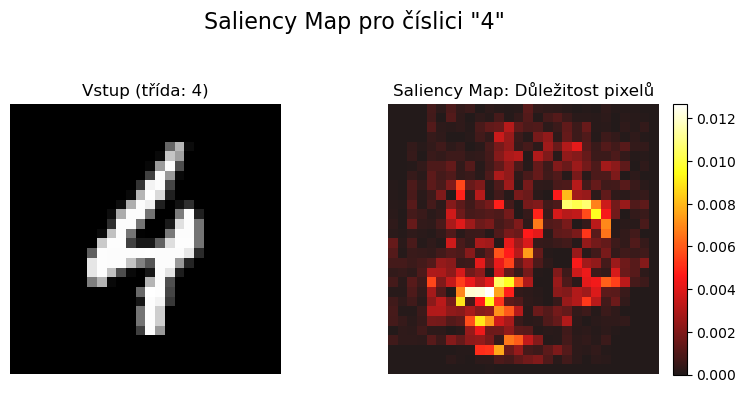


Saliency Map úspěšně ukázala, že síť se zaměřuje na klíčové tahy číslice '4'.


In [34]:
# %% [markdown]
# # 5. Vizualizace Saliency Map
# Zobrazení, které pixely ve vstupu měly největší vliv na rozhodnutí.

# %%
# Vstupní tensor je sample_image (s requires_grad=True)
input_tensor = sample_image 
target_category = sample_label 

# 1. Provedení dopředného průchodu a získání skóre cílové třídy
output = model(input_tensor)
target_score = output[0, target_category]

# 2. Vynulování gradientů a zpětná propagace
model.zero_grad()
target_score.backward()

# 3. Získání gradientu a Saliency Mapy
# Matice gradientů je v .grad atributu vstupního tenzoru
saliency_map = input_tensor.grad.abs().squeeze().cpu().numpy()

# 4. Normalizace původního obrázku pro zobrazení
mean = 0.1307
std = 0.3081
rgb_img = (input_tensor.detach().cpu().squeeze().numpy() * std + mean)

# 5. Vizualizace
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle(f'Saliency Map pro číslici "{target_category}"', fontsize=16)

# Původní obrázek
ax[0].imshow(rgb_img, cmap='gray')
ax[0].set_title(f'Vstup (třída: {target_category})')
ax[0].axis('off')

# Saliency Map
im = ax[1].imshow(saliency_map, cmap='hot', alpha=0.9)
ax[1].set_title('Saliency Map: Důležitost pixelů')
ax[1].axis('off')

fig.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)

plt.tight_layout(rect=[0, 0.03, 1, 0.90])
plt.show()

print(f"\nSaliency Map úspěšně ukázala, že síť se zaměřuje na klíčové tahy číslice '{target_category}'.")